# Topic Modeling with NMF and SVD

## The problem

Topic modeling is a fun way to start our study of NLP. We will use two popular **matrix decomposition techniques**. 

We start with a **term-document matrix**:

![title](../data/document_term.png "ShowMyImage") 

source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#)

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure.  It's an example of a **bag of words** approach.

Latent Semantic Analysis (LSA) uses Singular Value Decomposition (SVD).

### Motivation

Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics. 

## Getting started

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them.  Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**

In [1]:
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

## Look at our data

In [3]:
from sklearn.datasets import load_files

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

data = load_files(
    container_path="../data/20news-19997/20_newsgroups",
    categories=categories,
    encoding="latin-1",   # important for 20NG
    shuffle=True
)

X = data.data
y = data.target


In [4]:
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.data,
    data.target,
    test_size=0.2,
    random_state=42,
    stratify=data.target
)

newsgroups_train = Bunch(
    data=X_train,
    target=y_train,
    target_names=data.target_names
)

newsgroups_test = Bunch(
    data=X_test,
    target=y_test,
    target_names=data.target_names
)

Let's look at some of the data.  Can you guess which category these messages are in?

In [5]:
print("\n".join(newsgroups_train.data[:3]))

Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:121232 talk.religion.misc:84122 talk.politics.misc:179296
Newsgroups: talk.abortion,talk.religion.misc,talk.politics.misc
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!swrinde!sgiblab!sgigate!odin!sgihub!zola!eno.esd.sgi.com!cj
From: cj@eno.esd.sgi.com (C.J. Silverio)
Subject: Re: ABORTION and private health coverage -- letters regarding
Message-ID: <he8mnps@zola.esd.sgi.com>
Followup-To: talk.abortion
Sender: news@zola.esd.sgi.com (Net News)
Reply-To: cj@sgi.com
Organization: SGI Developer Docudramas
References: <1qid8s$ik0@agate.berkeley.edu> <93111.151829DGS4@psuvm.psu.edu>
Date: Wed, 21 Apr 93 22:04:14 GMT
Lines: 20


<DGS4@psuvm.psu.edu> writes:
| For an illustrative example in the opposite direction, it may be possible
| to ADD services to an insurance contract and REDUCE the premium.  If you
| add preventative services and this reduces a

hint: definition of *perijove* is the point in the orbit of a satellite of Jupiter nearest the planet's center 

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['talk.religion.misc', 'sci.space', 'sci.space'], dtype='<U18')

The target attribute is the integer index of the category.

In [7]:
newsgroups_train.target[:10]

array([3, 2, 2, 0, 1, 1, 3, 0, 1, 1])

In [8]:
num_topics, num_top_words = 6, 8

## Stop words, stemming, lemmatization

### Stop words

#### NLTK

In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sorted(list(ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

There is no single universal list of stop words.

### Stemming and Lemmatization

from [Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) textbook:

Are the below words the same?

*organize, organizes, and organizing*

*democracy, democratic, and democratization*

Stemming and Lemmatization both generate the root form of the words. 

Lemmatization uses the rules about a language.  The resulting tokens are all actual words

"Stemming is the poor-man’s lemmatization." (Noah Smith, 2011) Stemming is a crude heuristic that chops the ends off of words.  The resulting tokens may not be actual words. Stemming is faster.

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gyanr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
from nltk import stem

In [12]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [13]:
word_list = ['feet', 'foot', 'foots', 'footing']

In [14]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [15]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

Your turn!  Now, try lemmatizing and stemming the following collections of words:

- fly, flies, flying
- organize, organizes, organizing
- universe, university

fastai/course-nlp

Stemming and lemmatization are language dependent.  Languages with more complex morphologies may show bigger benefits.  For example, Sanskrit has a very [large number of verb forms](https://en.wikipedia.org/wiki/Sanskrit_verbs). 

### Spacy

Stemming and lemmatization are implementation dependent.

In [16]:
# %pip uninstall  spacy
# import spacy

### When to use these?

<img src="images/skomoroch.png" alt="" style="width: 65%"/>

These were long considered standard techniques, but they can often **hurt** your performance **if using deep learning**. Stemming, lemmatization, and removing stop words all involve throwing away information.

However, they can still be useful when working with simpler models.

### Another approach: sub-word units

[SentencePiece](https://github.com/google/sentencepiece) library from Google

## Data Processing

Next, scikit learn has a method that will extract all the word counts for us.  In the next lesson, we'll learn how to write our own version of CountVectorizer, to see what's happening underneath the hood.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [18]:
vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())

In [19]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(3200, 49542)

In [20]:
print(len(newsgroups_train.data), vectors.shape)

3200 (3200, 49542)


In [21]:
vocab = np.array(vectorizer.get_feature_names_out())

In [22]:
vocab.shape

(49542,)

In [23]:
vocab[7000:7020]

array(['38559', '3856', '38574', '38576', '38577', '38579', '38586',
       '38589', '38590', '38592', '38593', '38599', '386', '3860',
       '38600', '38604', '38612', '38613', '38618', '38622'], dtype=object)

## Singular Value Decomposition (SVD)

"SVD is not nearly as famous as it should be." - Gilbert Strang

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis

Latent Semantic Analysis (LSA) uses SVD.  You will sometimes hear topic modelling referred to as LSA.

In [24]:
from scipy import linalg
# %time U, s, Vh = linalg.svd(vectors, full_matrices=False)

In [26]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
vectors = np.asarray(vectors)
U = svd.fit_transform(vectors)
S = svd.singular_values_
Vh = svd.components_


In [27]:
print(U.shape, S.shape, Vh.shape)

(3200, 100) (100,) (100, 49542)


Confirm this is a decomposition of the input.

In [28]:
S[:4]

array([794.27845221, 615.02543123, 391.80429722, 359.61543158])

In [29]:
np.diag(np.diag(S[:4]))

array([794.27845221, 615.02543123, 391.80429722, 359.61543158])

#### Answer

In [30]:
#Exercise: confirm that U, s, Vh is a decomposition of `vectors`
#Takes a very long time
# import numpy as np
# from scipy import linalg
# 
# # vectors = your matrix (np.array or sparse)
# # Full SVD
# U, s, Vh = linalg.svd(vectors, full_matrices=False)
# 
# # Reconstruct
# S = np.diag(s)              # convert singular values to diagonal matrix
# vectors_reconstructed = U @ S @ Vh  # matrix multiplication
# 
# # Confirm
# np.allclose(vectors, vectors_reconstructed)  # True if decomposition is correct
# 


True

Confirm that U, V are orthonormal

import numpy as np
from scipy import linalg

# Full SVD
U, s, Vh = linalg.svd(vectors, full_matrices=False)

# Check U^T U = I
print("U orthonormal:", np.allclose(U.T @ U, np.eye(U.shape[1])))

# Check Vh Vh^T = I
print("Vh orthonormal:", np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0])))


#### Topics

What can we say about the singular values s?

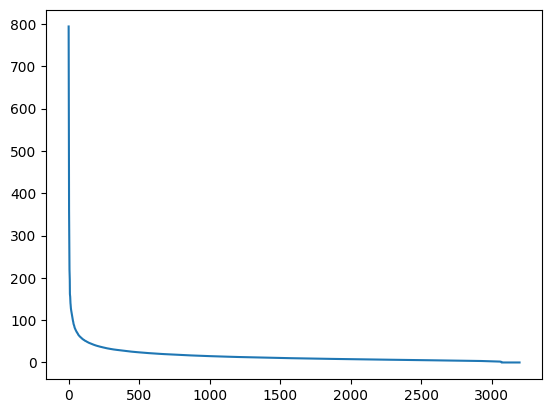

In [31]:
plt.plot(S);

 ...]

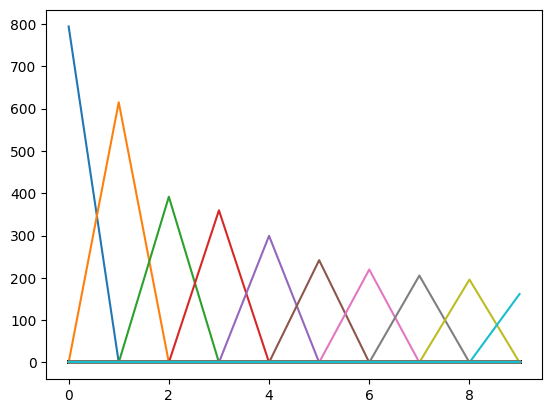

In [32]:
plt.plot(S[:10])

In [33]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [34]:
show_topics(Vh[:10])

['solist hogeschool harlow cm19 fearsome 9na 737376136 4777',
 'edu cmu com cs srv cantaloupe talk news',
 'edu graphics pub data ftp image comp cs',
 'jpeg cmu gif talk edu srv religion alt',
 'space earth planet spacecraft venus solar surface launch',
 'com atheism god religion people atheists does say',
 'space launch satellite sci data commercial market nasa',
 'com talk apple sgi sandvik jehovah misc elohim',
 'graphics space pub mail ray com send 128',
 'launch talk satellite commercial market edu satellites frank']

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised algorithm** - which is to say, we never actually told the algorithm how our documents are grouped.

We will return to SVD in **much more detail** later.  For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows.

## Non-negative Matrix Factorization (NMF)

#### Motivation

#### Idea

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

#### Applications of NMF

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

**More Reading**:

- [The Why and How of Nonnegative Matrix Factorization](https://arxiv.org/pdf/1401.5226.pdf)

### NMF from sklearn

We will use [scikit-learn's implementation of NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html):

In [35]:
m,n=vectors.shape
d=5  # num topics

In [36]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [37]:
show_topics(H1)

['edu cmu com cs news srv cantaloupe net',
 'jpeg image gif file color images format quality',
 'jehovah god elohim lord christ father mcconkie jesus',
 'edu graphics data image ftp pub available mail',
 'space earth planet venus spacecraft solar nasa surface']

### TF-IDF

[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [38]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [39]:
newsgroups_train.data[10:20]

['Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:84280 alt.religion.kibology:8350 alt.spam:27\nNewsgroups: talk.religion.misc,alt.religion.kibology,alt.spam\nPath: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!munnari.oz.au!bruce.cs.monash.edu.au!monu6!aurora.cc.monash.edu.au!ins559n\nFrom: ins559n@aurora.cc.monash.edu.au (Andrew Bulhak)\nSubject: Re: New Religion Forming -- Sign Up\nMessage-ID: <1993Apr26.004116.10087@monu6.cc.monash.edu.au>\nSender: news@monu6.cc.monash.edu.au (Usenet system)\nOrganization: Monash University\nX-Newsreader: TIN [version 1.1 PL6]\nReferences: <-g25zll@rpi.edu>\nDate: Mon, 26 Apr 1993 00:41:16 GMT\nLines: 33\n\nJim Kasprzak (kasprj@isaac.its.rpi.edu) wrote:\n: In article <=4z5wqc@rpi.edu>, weinss@rs6101.ecs.rpi.edu (Stephen Andrew Weinstein) writes:\n: |> Let me begin by saying I think this is the world\'s first religion to use\n: |> the net as its major recruitment medium.  Therefore, even if this\n: |> religion does not take of

In [40]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [41]:
show_topics(H1)

['edu cmu cs com space sci news srv',
 'mchp sni frank ap horus objective talk d012s658',
 'sandvik apple kent com newton gallant edu talk',
 'sgi caltech livesey gap fido solntze wpd asd',
 'uiuc cso cobb edu alexia lis urbana illinois']

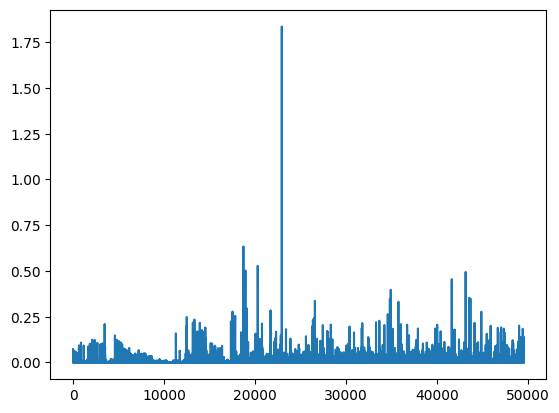

In [42]:
plt.plot(clf.components_[0])

In [43]:
clf.reconstruction_err_

np.float64(54.45353812618494)

### NMF in summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:
- For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
- Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

## Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD.  We are just interested in the vectors corresponding to the **largest** singular values.

<img src="images/svd_fb.png" alt="" style="width: 80%"/>

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

#### Shortcomings of classical algorithms for decomposition:

- Matrices are "stupendously big"
- Data are often **missing or inaccurate**.  Why spend extra computational resources when imprecision of input limits precision of the output?
- **Data transfer** now plays a major role in time of algorithms.  Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
- Important to take advantage of **GPUs**.

(source: [Halko](https://arxiv.org/abs/0909.4061))

#### Advantages of randomized algorithms:

- inherently stable
- performance guarantees do not depend on subtle spectral properties
- needed matrix-vector products can be done in parallel

(source: [Halko](https://arxiv.org/abs/0909.4061))

### Timing comparison

In [44]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: total: 8min 40s
Wall time: 1min 39s


KeyboardInterrupt: 

In [ ]:
from sklearn import decomposition
import fbpca

In [ ]:
%time u, s, v = decomposition.randomized_svd(vectors, 10)

Randomized SVD from Facebook's library fbpca:

In [ ]:
%time u, s, v = fbpca.pca(vectors, 10)

For more on randomized SVD, check out my [PyBay 2017 talk](https://www.youtube.com/watch?v=7i6kBz1kZ-A&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=7).

For significantly more on randomized SVD, check out the [Computational Linear Algebra course](https://github.com/fastai/numerical-linear-algebra).

## End